In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
import scipy.io as sio
import torch.optim as optim
from torch.autograd import Variable
from livelossplot import PlotLosses

## Set parameters

In [39]:
batch_size = 64

test_batch_size = 4449

opt = 'Adam'

epochs = 30

lr =0.0005

momentum = 0.5

no_cuda = False

seed = 1

wait =20

cuda = not no_cuda and torch.cuda.is_available()

## Load data

In [40]:
tr_data = sio.loadmat('../data/sarcos_inv.mat')
Ntr = tr_data['sarcos_inv'].shape[0]
xtr = tr_data['sarcos_inv'][:,:21]
ytr = tr_data['sarcos_inv'][:,21:]

xtr = torch.from_numpy(xtr).float()
ytr = torch.from_numpy(ytr).float()

ts_data = sio.loadmat('../data/sarcos_inv_test.mat')
Nts = ts_data['sarcos_inv_test'].shape[0]
xts = ts_data['sarcos_inv_test'][:,:21]
yts = ts_data['sarcos_inv_test'][:,21:]

xts = torch.from_numpy(xts).float()
yts = torch.from_numpy(yts).float()

##
trainset = torch.utils.data.TensorDataset(xtr,ytr)
testset = torch.utils.data.TensorDataset(xts,yts)

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, **kwargs)
test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, **kwargs)


## Design DNN 

In [41]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc1 = nn.Linear(21, 200)
        self.fc2 = nn.Linear(200, 500)
        self.drop1 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(500, 500)
        self.fc4 = nn.Linear(500, 7)
        
    def forward(self, x):
        x = x.view(-1, 21)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.drop1(x)
        x = F.relu(self.fc3(x))
        return self.fc4(x)  


model = LinearNet()



if cuda:
    model.cuda()
    
print('\n---Model Information---')
print('Net:',model)
print('Use GPU:', cuda)



---Model Information---
Net: LinearNet(
  (fc1): Linear(in_features=21, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=500, bias=True)
  (drop1): Dropout(p=0.5)
  (fc3): Linear(in_features=500, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=7, bias=True)
)
Use GPU: True


## Set optimizer 

In [42]:
optimizer = None
if opt =='SGD':
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
elif opt =='Adam':
    optimizer = optim.Adam(model.parameters(), lr=lr)
elif opt =='Adadelta':
    optimizer = optim.Adadelta(model.parameters())
else:
    print('Wrong name of optimizer')
    
print('\n---Training Details---')
print('batch size:',batch_size)
print('seed number', seed)

print('\n---Optimization Information---')
print('optimizer:', optimizer)
if opt != 'Adadelta':
	print('lr:', lr)



---Training Details---
batch size: 64
seed number 1

---Optimization Information---
optimizer: <torch.optim.adam.Adam object at 0x7f99407105c0>
lr: 0.0005


## Train and plot live 

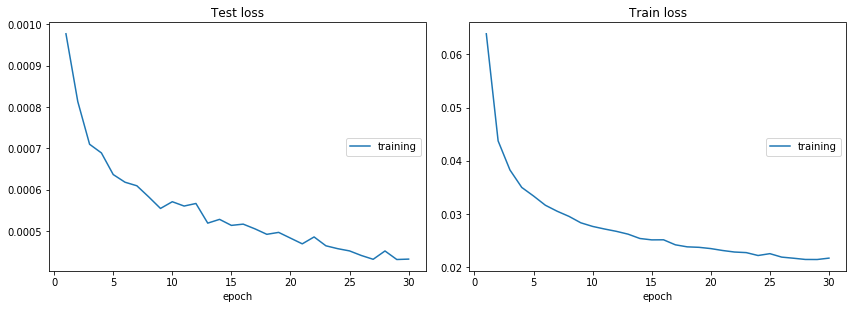

Test loss: 0.0004315189791143704


In [43]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target).float()
        optimizer.zero_grad()
        output = model(data)
        loss = F.l1_loss(output, target)
        loss.backward()
        optimizer.step()
        #Total train Loss
        train_loss += loss.data[0]
    return train_loss/len(train_loader.dataset)


def test():
    model.eval()
    test_loss = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target).float()
        output = model(data)
        test_loss += F.l1_loss(output, target).data[0] 
        
    test_loss /= len(test_loader.dataset)
#     print('\nTest set: Average loss: {:.4f}'.format(test_loss))
    return test_loss


liveloss = PlotLosses()

for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_loss = test()
    liveloss.update({
        'Test loss': test_loss,
        'Train loss': train_loss,
    })
    liveloss.draw()

print('Test loss: {}'.format(test_loss))